
📍 Processing city: Pune

🌡️ Pune - Temperature RMSE: 0.94 °C
🌧️ Pune - Precipitation Probability RMSE: 0.017
🌤️ Pune - Weather Condition Accuracy: 87.08%
              precision    recall  f1-score   support

       clear       0.95      0.90      0.92       639
       rainy       0.55      0.71      0.62       112

    accuracy                           0.87       751
   macro avg       0.75      0.80      0.77       751
weighted avg       0.89      0.87      0.88       751



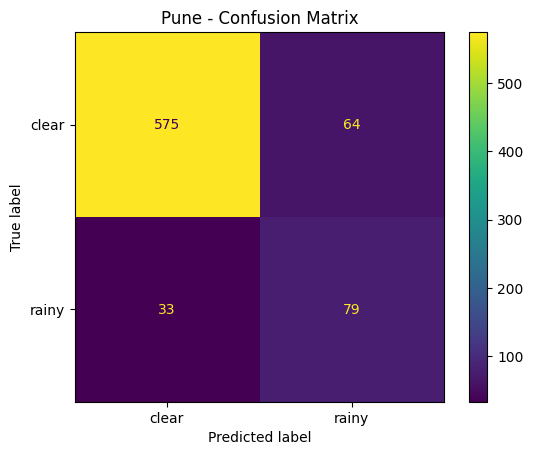

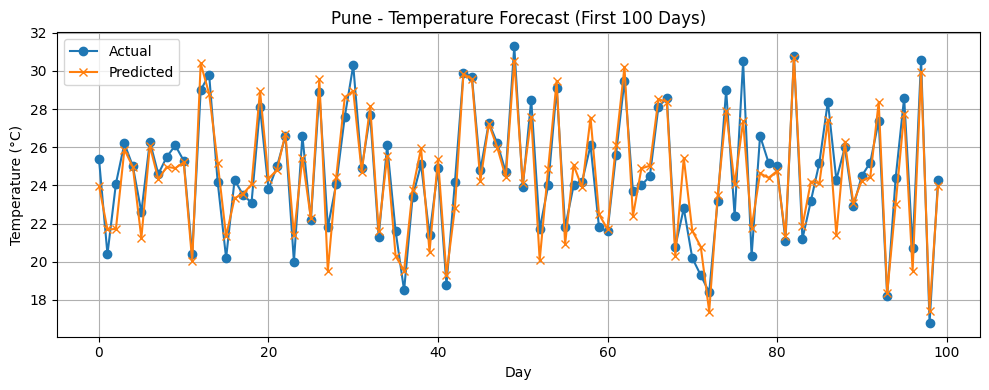

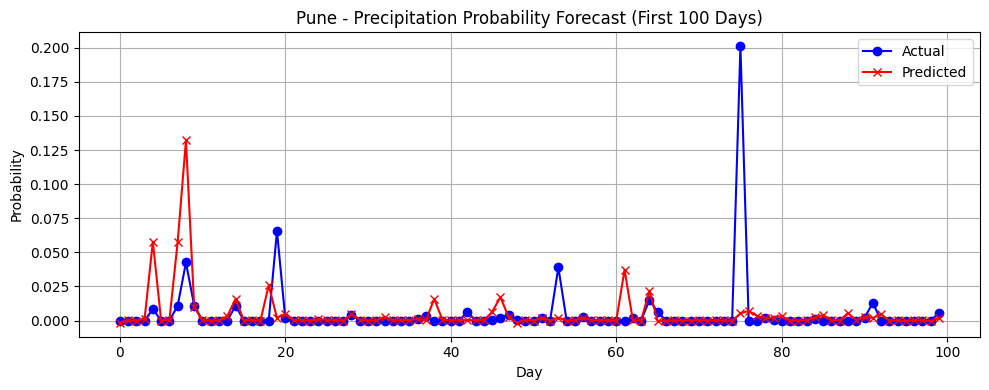

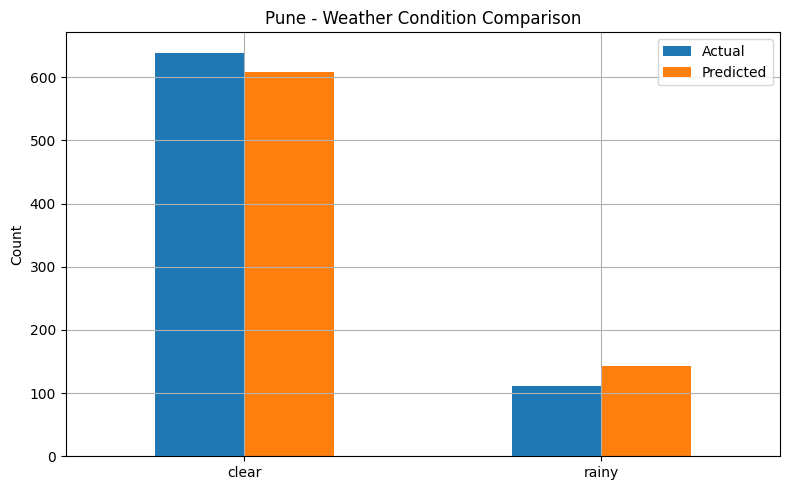


📁 CSV exported: pune_weather_forecast.csv

📍 Processing city: Delhi

🌡️ Delhi - Temperature RMSE: 1.54 °C
🌧️ Delhi - Precipitation Probability RMSE: 0.037
🌤️ Delhi - Weather Condition Accuracy: 88.02%
              precision    recall  f1-score   support

       clear       0.92      0.94      0.93       648
       rainy       0.58      0.48      0.52       103

    accuracy                           0.88       751
   macro avg       0.75      0.71      0.73       751
weighted avg       0.87      0.88      0.88       751



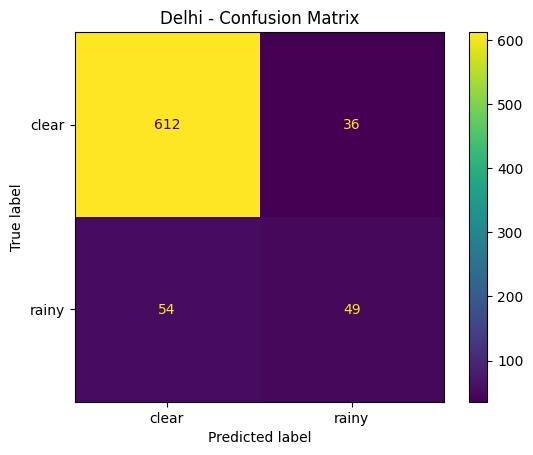

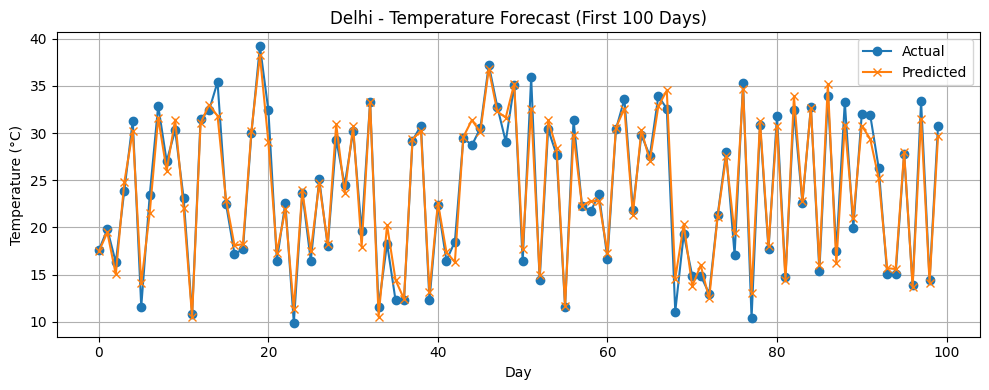

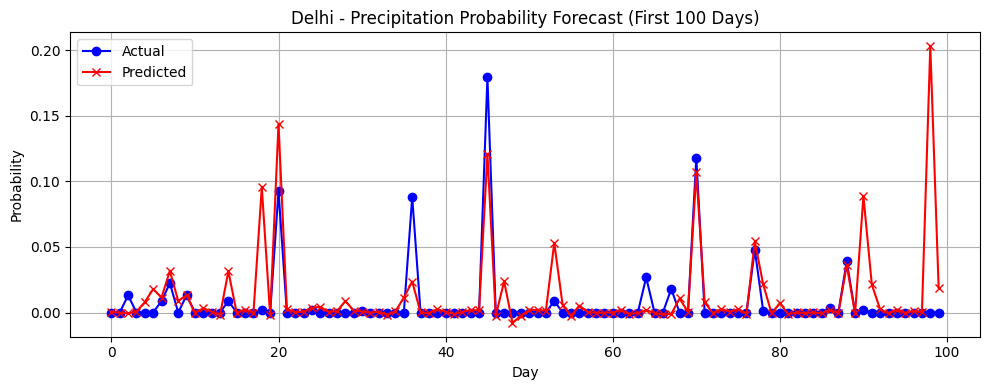

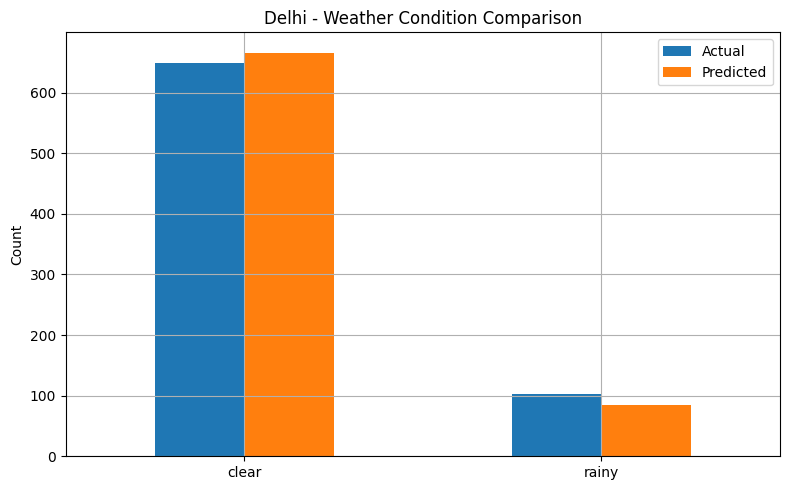


📁 CSV exported: delhi_weather_forecast.csv

📍 Processing city: Bangalore

🌡️ Bangalore - Temperature RMSE: 0.90 °C
🌧️ Bangalore - Precipitation Probability RMSE: 0.076
🌤️ Bangalore - Weather Condition Accuracy: 80.69%
              precision    recall  f1-score   support

       clear       0.89      0.86      0.87       579
       rainy       0.57      0.64      0.60       172

    accuracy                           0.81       751
   macro avg       0.73      0.75      0.74       751
weighted avg       0.82      0.81      0.81       751



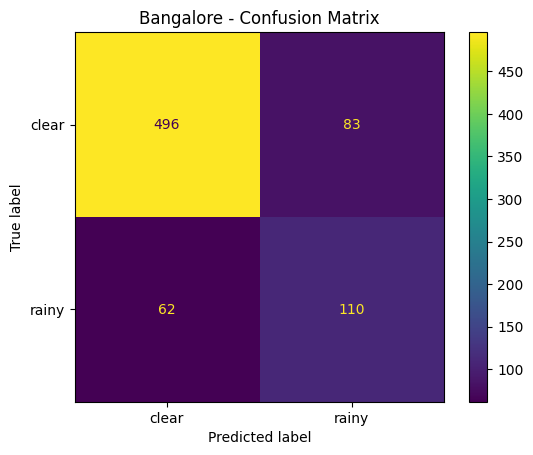

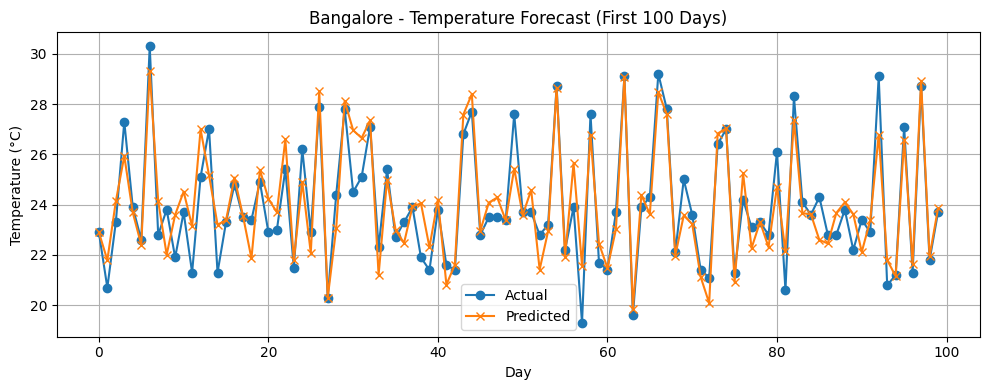

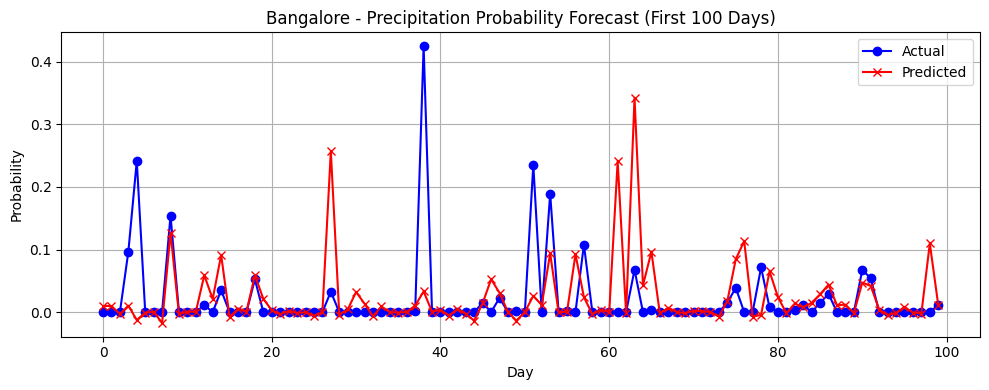

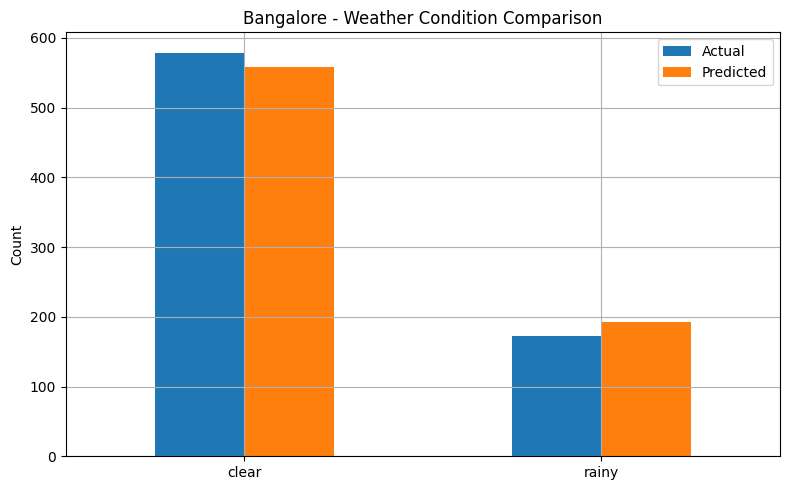


📁 CSV exported: bangalore_weather_forecast.csv

📍 Processing city: Jaipur

🌡️ Jaipur - Temperature RMSE: 1.51 °C
🌧️ Jaipur - Precipitation Probability RMSE: 0.043
🌤️ Jaipur - Weather Condition Accuracy: 90.15%
              precision    recall  f1-score   support

       clear       0.94      0.95      0.95       678
       rainy       0.49      0.47      0.48        73

    accuracy                           0.90       751
   macro avg       0.72      0.71      0.71       751
weighted avg       0.90      0.90      0.90       751



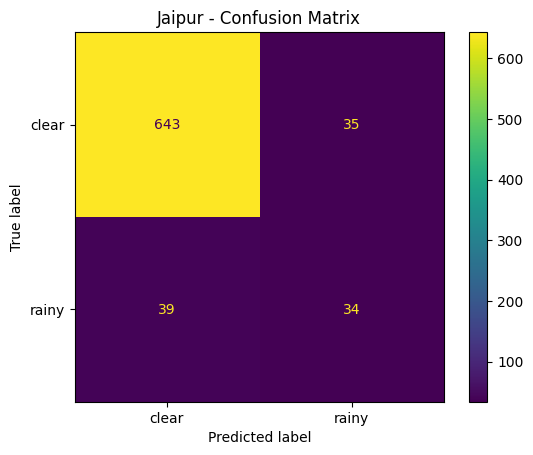

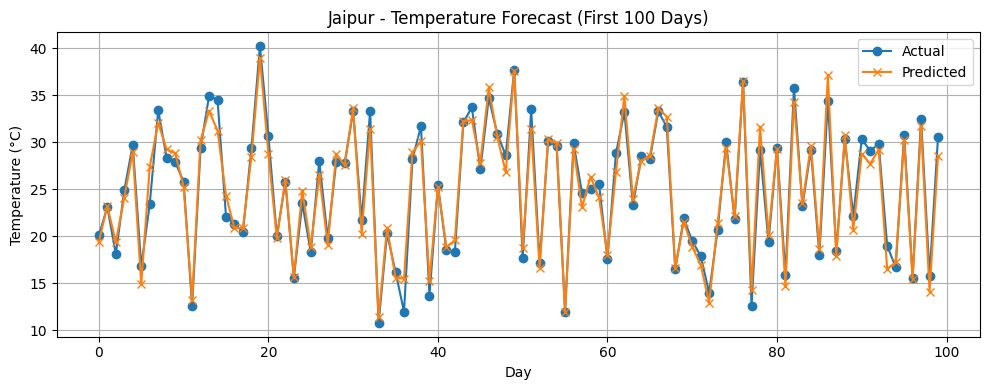

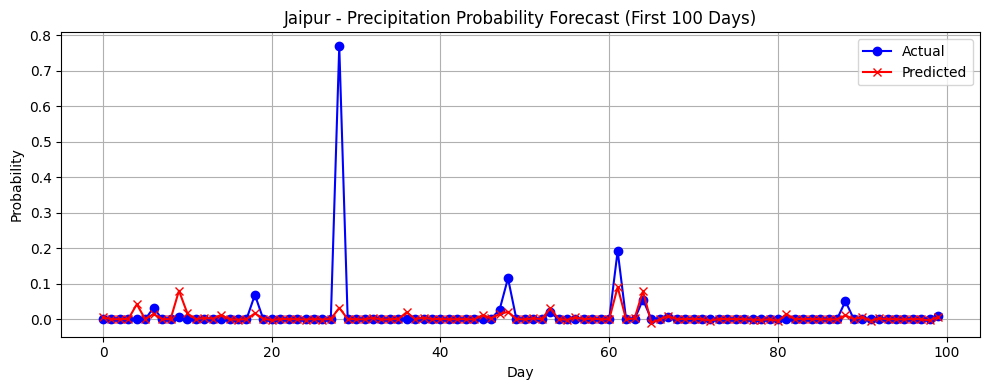

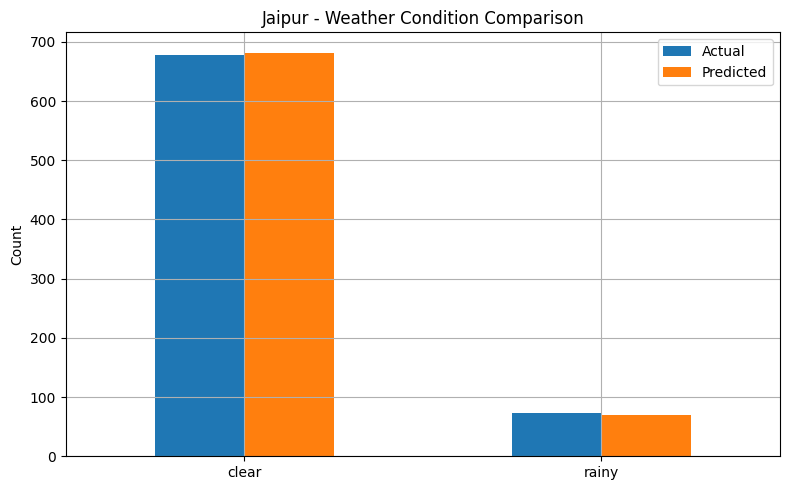


📁 CSV exported: jaipur_weather_forecast.csv


In [4]:
# Imports
from meteostat import Point, Daily, Hourly
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# City coordinates
cities = {
    'Pune': (18.5204, 73.8567),
    'Delhi': (28.6139, 77.2090),
    'Bangalore': (12.9716, 77.5946),
    'Jaipur': (26.9124, 75.7873)
}

start = datetime(2015, 1, 1)
end = datetime(2025, 4, 10)

def process_city(city_name, lat, lon):
    print(f"\n📍 Processing city: {city_name}")
    location = Point(lat, lon)

    # Daily weather
    daily = Daily(location, start, end).fetch().reset_index()
    daily.rename(columns={
        'time': 'date_time',
        'tavg': 'temperature',
        'prcp': 'precipitation',
        'wspd': 'wind_speed',
        'pres': 'pressure'
    }, inplace=True)
    daily = daily[['date_time', 'temperature', 'tmin', 'tmax', 'precipitation', 'wind_speed', 'pressure']]
    daily.fillna(daily.median(numeric_only=True), inplace=True)

    # Hourly humidity
    hourly = Hourly(location, start, end).fetch().reset_index()
    hourly['date_time'] = hourly['time'].dt.date
    humidity = hourly.groupby('date_time')['rhum'].mean().reset_index()
    humidity.rename(columns={'rhum': 'humidity'}, inplace=True)
    humidity['date_time'] = pd.to_datetime(humidity['date_time'])

    # Merge and clean
    df = pd.merge(daily, humidity, on='date_time', how='left')
    df['forecasted_temperature'] = df['temperature'].shift(-1)
    max_precip = df['precipitation'].max()
    df['precipitation_probability'] = df['precipitation'] / (max_precip + 0.001)
    df['forecasted_precip_prob'] = df['precipitation_probability'].shift(-1)
    df['weather_condition'] = np.where(df['precipitation'] > 1.0, 'rainy', 'clear')
    df['forecasted_condition'] = df['weather_condition'].shift(-1)

    # Time features
    df['month'] = df['date_time'].dt.month
    df['day_of_year'] = df['date_time'].dt.dayofyear
    df['season'] = df['month'] % 12 // 3 + 1
    df['is_monsoon'] = df['month'].isin([6, 7, 8, 9]).astype(int)
    df.dropna(inplace=True)

    # Features & Targets
    features = ['temperature', 'tmin', 'tmax', 'wind_speed', 'pressure',
                'precipitation', 'humidity', 'month', 'day_of_year', 'season', 'is_monsoon']
    
    target_temp = 'forecasted_temperature'
    target_precip = 'forecasted_precip_prob'
    target_cond = 'forecasted_condition'

    le = LabelEncoder()
    df['forecasted_condition_encoded'] = le.fit_transform(df['forecasted_condition'])

    X = df[features]
    y_temp = df[target_temp]
    y_precip = df[target_precip]
    y_cond = df['forecasted_condition_encoded']

    # Splits
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)
    X_train_precip, X_test_precip, y_train_precip, y_test_precip = train_test_split(X, y_precip, test_size=0.2, random_state=42)
    X_train_cond, X_test_cond, y_train_cond, y_test_cond = train_test_split(X, y_cond, test_size=0.2, random_state=42)

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train_cond, y_train_cond)

    # Train models
    reg_temp = XGBRegressor(n_estimators=100, random_state=42)
    reg_precip = XGBRegressor(n_estimators=100, random_state=42)
    cls_cond = XGBClassifier(n_estimators=100, random_state=42)

    reg_temp.fit(X_train_temp, y_train_temp)
    reg_precip.fit(X_train_precip, y_train_precip)
    cls_cond.fit(X_resampled, y_resampled)

    # Predictions
    df['predicted_temperature'] = reg_temp.predict(X)
    df['predicted_precip_prob'] = reg_precip.predict(X)
    df['predicted_condition_encoded'] = cls_cond.predict(X)
    df['predicted_condition'] = le.inverse_transform(df['predicted_condition_encoded'])

    # Evaluation
    y_pred_temp = reg_temp.predict(X_test_temp)
    y_pred_precip = reg_precip.predict(X_test_precip)
    y_pred_cond = cls_cond.predict(X_test_cond)

    rmse_temp = np.sqrt(mean_squared_error(y_test_temp, y_pred_temp))
    rmse_precip = np.sqrt(mean_squared_error(y_test_precip, y_pred_precip))
    acc_cond = accuracy_score(y_test_cond, y_pred_cond)

    print(f"\n🌡️ {city_name} - Temperature RMSE: {rmse_temp:.2f} °C")
    print(f"🌧️ {city_name} - Precipitation Probability RMSE: {rmse_precip:.3f}")
    print(f"🌤️ {city_name} - Weather Condition Accuracy: {acc_cond:.2%}")
    print(classification_report(y_test_cond, y_pred_cond, target_names=le.classes_))

    # Visuals
    cm = confusion_matrix(y_test_cond, y_pred_cond)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot()
    plt.title(f"{city_name} - Confusion Matrix")
    plt.show()
        # 1. 📊 Temperature: Actual vs Predicted
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_temp.values[:100], label='Actual', marker='o')
    plt.plot(y_pred_temp[:100], label='Predicted', marker='x')
    plt.title(f'{city_name} - Temperature Forecast (First 100 Days)')
    plt.xlabel('Day')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. 🌧️ Precipitation Probability: Actual vs Predicted
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_precip.values[:100], label='Actual', marker='o', color='blue')
    plt.plot(y_pred_precip[:100], label='Predicted', marker='x', color='red')
    plt.title(f'{city_name} - Precipitation Probability Forecast (First 100 Days)')
    plt.xlabel('Day')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. 🌤️ Weather Condition: Actual vs Predicted Bar Plot
    actual_counts = pd.Series(le.inverse_transform(y_test_cond)).value_counts().sort_index()
    predicted_counts = pd.Series(le.inverse_transform(y_pred_cond)).value_counts().sort_index()

    df_bar = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})
    df_bar.plot(kind='bar', figsize=(8, 5), rot=0)
    plt.title(f'{city_name} - Weather Condition Comparison')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Export
    filename = f"{city_name.lower().replace(' ', '_')}_weather_forecast.csv"
    df.to_csv(filename, index=False)
    print(f"\n📁 CSV exported: {filename}")

# Run for all cities
for city, (lat, lon) in cities.items():
    process_city(city, lat, lon)
